$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Neural Network Regression

Fawad Ahmad

## $Overview$

**Objective:** To implement ridge regression and neural networks on the Data Set and find the best results.

**Method:** I take different lambda values in case of Linear model and find the best result. Whereas, I take different parameters with values giving information about hidden layers and iterations in case of Neural networks

**Data source:**  http://archive.ics.uci.edu/ml/machine-learning-databases/housing/

**Results:** 

1. Linear model has more error then Neural Network model 
2. Linear model gets better with high lambda value but it also depends on the training set selection.
3. Neural Network model error is less with number of iterations in case of single hidden layer
4. Neural Network model can get same accuracy metioned in "3" with more hidden layers and less iterations
5. Neural Network model training also depends on the training set so sometimes less hidden layers with less no of iterations also gives best result.

## $Functions$

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import scaledconjugategradient as scg
import mlutils as ml  # for draw()
from copy import copy
import neuralnetworks as nn
import imp

### $Train Linear$

In [2]:
 def trainLinear(X, T, lamb):   
    means = X.mean(0)
    stds = X.std(0)
    n,d = X.shape
    Xs1 = np.insert( (X - means)/stds, 0, 1, axis=1)
    lambDiag = np.eye(d+1) * lamb
    lambDiag[0,0] = 0
    w = np.linalg.lstsq( Xs1.T.dot(Xs1) + lambDiag, Xs1.T.dot(T))[0]
    return {'w': w, 'means':means, 'stds':stds}

### $EvaluateLinear$

In [3]:
def evaluateLinear(model, X, T):
    Xs1 = np.insert((X-model['means'])/model['stds'], 0, 1, axis=1)
    A = Xs1.dot(model['w'])
    return np.sqrt(np.mean( (A-T)**2 ))

### $Train NN$

In [4]:
def trainNN(X, T, parameter):
    #print(parameter[0])
    #print(parameter[1])
    global nnet
    nnet = nn.NeuralNetwork(X.shape[1], parameter[0], 1)
    Model = nnet.train(X, T, parameter[1])
    return Model

### $Evaluate NN$

In [5]:
def evaluateNN(Model, X, T):
    global Y
    Y = Model.use(X)
    #print(np.sqrt(np.mean(Y - T)**2))
    return np.sqrt(np.mean(Y - T)**2)

### $TrainValidateTestKFolds$

In [6]:

def trainValidateTestKFolds(trainNN,evaluateNN,X,T,parameterSets,nFolds, shuffle=False,verbose=False):
    import matplotlib.pyplot as plt
    global I   # for the seperate graph of best values
    global IT 
    global O
    global OT
    global y1
    global y2 
    global paro
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    # Calculate number of samples in each of the nFolds folds
    nSamples = X.shape[0]
    nEach = int(nSamples / nFolds)
    if nEach == 0:
        raise ValueError("partitionKFolds: Number of samples in each fold is 0.")
    # Calculate the starting and stopping row index for each fold.
    # Store in startsStops as list of (start,stop) pairs
    starts = np.arange(0,nEach*nFolds,nEach)
    stops = starts + nEach
    stops[-1] = nSamples
    startsStops = list(zip(starts,stops))
    # Repeat with testFold taking each single fold, one at a time
    results = []
    
    parameters = []
    result = []
    count = 0
    count1 = 0
    error_val = []
    error_train = []
    error_test = []
    error1_train = []
    error1_test = []    
    error = []
    besterror = 0.0
    mean = 0.0
    Xtn = []
    Ttn = []
    Xtst = []
    Ttst = []
    para = []
    paro = []
    I = []
    IT = []
    O = []
    OT = []
    y1 = []
    y2 = []
    for testFold in range(nFolds):
        count = 0
        #p =[]
        #print(p)
        for parmSet in parameterSets:
            #if nPartitions == 3:
            # Repeating it again with validateFold taking each single fold, except for the testFold
               error = []
               #print(error)
               for validateFold in range(nFolds):
                    if testFold == validateFold:
                        continue
                    # trainFolds are all remaining folds, after selecting test and validate folds
                    trainFolds = np.setdiff1d(range(nFolds), [testFold,validateFold])
                    # Constructing Xtrain and Ttrain by collecting rows for all trainFolds
                    rows = []
                    for tf in trainFolds:
                        a,b = startsStops[tf]                
                        rows += rowIndices[a:b].tolist()
                    Xtrain = X[rows,:]
                   # print Xtrain
                    Ttrain = T[rows,:]
                    # Constructing Xval and Tval
                    a,b = startsStops[validateFold]
                    rows = rowIndices[a:b]
                    Xvalidate = X[rows,:]
                    Tvalidate = T[rows,:]
                    #Constructing Xtest and Ttest
                    a,b = startsStops[testFold]
                    rows = rowIndices[a:b]
                    Xtest = X[rows,:]
                    Ttest = T[rows,:]
                    #print(parmSet)
                    if type(parameterSets[0]) == tuple:
                        model = trainNN(Xtrain,Ttrain,parmSet) 
                        k = evaluateNN(model,Xvalidate,Tvalidate)
                    else:
                        model = trainLinear(Xtrain,Ttrain,parmSet) 
                        k = evaluateLinear(model,Xvalidate,Tvalidate)                        
                    #if k < 2:
                    
                    error.append(k) #it should be zero for next parmSet
                    #print(error)
                    
               mean = np.mean(error)
               if (count == 0):
                    #print(count)
                    besterror = mean
                    itrain = np.vstack((Xtrain, Xvalidate))
                    otrain = np.vstack((Ttrain, Tvalidate))
                    ival = Xvalidate
                    oval = Tvalidate
                    itest = Xtest
                    otest = Ttest
                    para = parmSet
                    #print(para)
               if (count > 0) & (besterror > mean):
                    #print(count)
                    besterror = mean
                    itrain = np.vstack((Xtrain, Xvalidate))
                    otrain = np.vstack((Ttrain, Tvalidate))
                    ival = Xvalidate
                    oval = Tvalidate
                    itest = Xtest
                    otest = Ttest
                    para = parmSet
                    #print(para)
               count = count + 1 
               I.append(itrain)
               O.append(otrain)           
        if type(parameterSets[0]) == tuple:
            model = trainNN(itrain,otrain,para)
            error1_test.append(evaluateNN(model,itest,otest))
            IT.append(itest)
            y1.append(Y)
            OT.append(otest)
            error1_train.append(evaluateNN(model,itrain,otrain))
            y2.append(Y)
            plt.figure(figsize=(15, 15))

            nHLayers = len(nnet.nhs)
            nPlotRows = 3 + nHLayers

            plt.subplot(nPlotRows, 1, 1)
            plt.plot(nnet.getErrors())
            plt.title('Regression Model Of Fold %d'%(count1+1))
            count1 = count1+1
        else:
            model = trainLinear(itrain,otrain,para)  
            k = evaluateLinear(model,itest,otest)
            error1_test.append(k)
            k = evaluateLinear(model,itrain,otrain)
            error1_train.append(k) 
        parameters.append(para)
        error_val.append(besterror)
    count1 = 0
    paro = parameters
    result = [parameters, error1_train, error_val, error1_test] 
    result = np.array(result).T
    return(result)

## $Data$

### $Example$ $1$

**Source:**  http://archive.ics.uci.edu/ml/machine-learning-databases/housing/

**Description:** This dataset contains 506 instances and 14 attributes. The first 13 attributes were used as sample features $X$, and the last one (*MEDV* : Median value of owner-occupied homes in \$1000's) was used as target $T$. The names and meanings of the 13 features are:
1. *CRIM *:      per capita crime rate by town
2. *ZN* :        proportion of residential land zoned for lots over 25,000 sq.ft.
3. *INDUS* :     proportion of non-retail business acres per town
4. *CHAS* :      Charles River dummy variable ( 1 if tract bounds river; 0 otherwise)
5. *NOX* :       nitric oxides concentration (parts per 10 million)
6. *RM* :        average number of rooms per dwelling
7. *AGE* :       proportion of owner-occupied units built prior to 1940
8. *DIS* :      weighted distances to five Boston employment centres
9. *RAD* :      index of accessibility to radial highways
10. *TAX* :     full-value property-tax rate per \$10,000
11. *PTRATIO* :  pupil-teacher ratio by town
12. *B* :        $1000(B_k - 0.63)^2$ where $B_k$ is the proportion of blacks by town
13. *LSTAT* :    % lower status of the population


In [19]:
data = np.loadtxt("housing.data")
X = data[:,1:5]
T = data[:,0:1 ]
print(X.shape,T.shape)
plt.figure(1)
plt.figure(figsize=(10,10))
names =  ['CRIM','ZN','INDUS','CHAS','NOX',
          'RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
Xnames = ['ZN','INDUS','CHAS','NOX']
Tname = names[0]
for c in range(X.shape[1]):
    plt.subplot(2,2, c+1)
    plt.plot(X[:,c], T, 'o', alpha=0.5)
    plt.title('%s Vs %s'%(Xnames[c],Tname))
    plt.ylabel(Tname)
    plt.xlabel(Xnames[c])

(506, 4) (506, 1)


NameError: name 'plt' is not defined

In [20]:
X.shape[1]

4

**Description of Data:**

Results above shows some very interesting behaviours.ZN(proportion of residential land) has more crime rate when it's less and then it decrease. Whereas, INDUS(proportion of non-retail business acres per town) has equal crime rate except near 20. similarly, NOX(nitric oxides concentration (parts per 10 million)) seems to have more effect on crime rate when it's larger. And CHAS shows that maximum crime rate is away from river side.

## $Linear Model$

### $Results $

In [8]:
result = trainValidateTestKFolds(trainLinear, evaluateLinear ,X, T, range(0,101,10), nFolds=5, shuffle=False)
print('Linear Model\n{:^10s} {:>10s} {:>10s} {:>10s}'.format('lambda', 'train', 'validate', 'test RMSE'))
for x in result:
    print('{:^10.2f} {:>10.3f} {:10.3f} {:10.3f}'.format(*x))

Linear Model
  lambda        train   validate  test RMSE
  100.00        8.559      8.439      1.681
  60.00         7.844      6.602      7.914
  10.00         8.496      8.361      2.598
  100.00        6.956      6.535     10.407
  100.00        5.651      5.359     13.541


The results shows that the error decreases by increasing the value of lambda but not always as it also depends on the values of training set.

### $Graph$ $for$ $Linear$

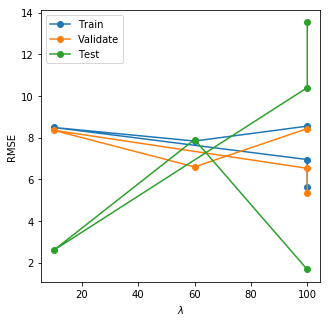

In [9]:
plt.figure(figsize=(5,5))
plt.plot(result[:,0],result[:,1:],'-o')
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.legend(('Train','Validate','Test'),loc='best')

## $Neural$ $network$ $Model$

### $Results$

NN Model
    (Hidden Units, Iterations)      train   validate  test RMSE
                     (10, 100)      0.015      1.356      0.036
                       (2, 10)      0.231      0.440      6.145
                      (5, 100)      0.092      1.848      1.493
                 ([5, 5], 500)      0.002      3.075      5.861
                     (10, 100)      0.012      1.560      3.465


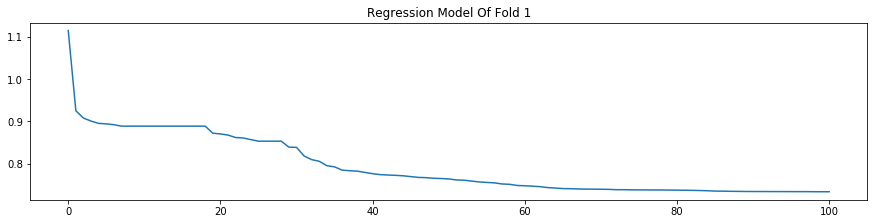

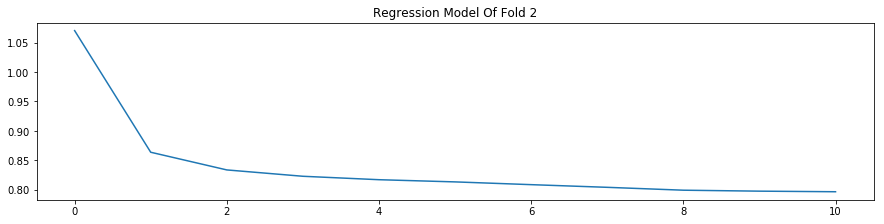

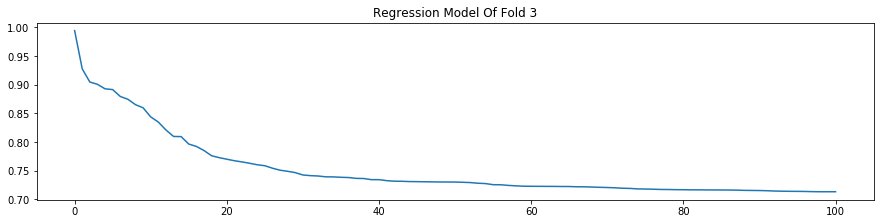

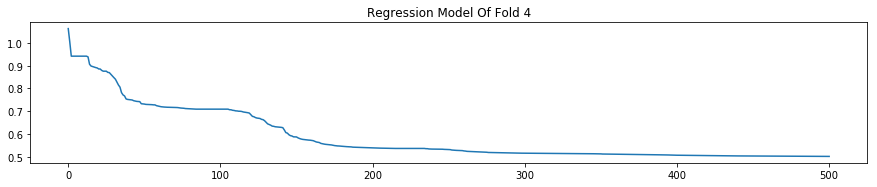

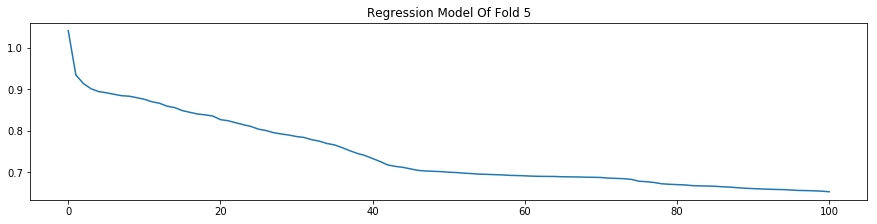

In [10]:
parms = list(itertools.product([2, 5, 10, 20, [5, 5], [10, 2, 10]], [10, 20, 100, 500]))
result = trainValidateTestKFolds(trainNN, evaluateNN, X, T, parms, nFolds=5, shuffle=False);
print('NN Model\n{:>30s} {:>10s} {:>10s} {:>10s}'.format('(Hidden Units, Iterations)', 'train', 'validate', 'test RMSE'))
for x in result:
     print('{:>30s} {:10.3f} {:10.3f} {:10.3f}'.format(str(x[0]), *x[1:]))

The results shows that In this cas as the data is big so parameters with more hidden layers give less error and it also depends on the training data as in linear model.

### $Example$ $2$

#### Second Data Set

In [11]:
nSamples = 10
X = np.linspace(0, 10, nSamples).reshape((-1, 1))
T = 1.5 + 0.6 * X + 0.8 * np.sin(1.5*X)
T[np.logical_and(X > 2, X < 3)] *= 3
T[np.logical_and(X > 5, X < 7)] *= 3

## $Linear Model$

### $Results$

In [12]:
result = trainValidateTestKFolds(trainLinear, evaluateLinear ,X, T, range(0,101,10), nFolds=5, shuffle=False)
print('Linear Model\n{:^10s} {:>10s} {:>10s} {:>10s}'.format('lambda', 'train', 'validate', 'test RMSE'))
for x in result:
    print('{:^10.2f} {:>10.3f} {:10.3f} {:10.3f}'.format(*x))

Linear Model
  lambda        train   validate  test RMSE
  100.00        4.614      4.614      6.202
  100.00        5.071      5.282      3.457
  10.00         3.640      3.806      7.221
  40.00         4.362      4.188      6.068
   0.00         4.370      4.825      6.401


The results shows that the error decreases by increasing the value of lambda but not always as it also depends on the values of training set.

### $Graphs$ $For$ $Linear$

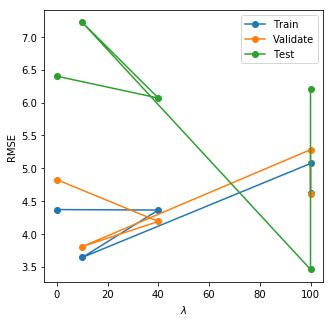

In [13]:
plt.figure(figsize=(5,5))
plt.plot(result[:,0],result[:,1:],'-o')
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.legend(('Train','Validate','Test'),loc='best')

## $Neural$ $Network$ $Model$

### $Results$

NN Model
    (Hidden Units, Iterations)      train   validate  test RMSE
             ([10, 2, 10], 20)      0.066      2.054      3.273
                       (5, 20)      0.002      3.281      3.417
             ([10, 2, 10], 10)      0.082      2.256      2.733
                  ([5, 5], 10)      0.134      2.674      0.777
                  ([5, 5], 10)      0.619      1.900      0.646


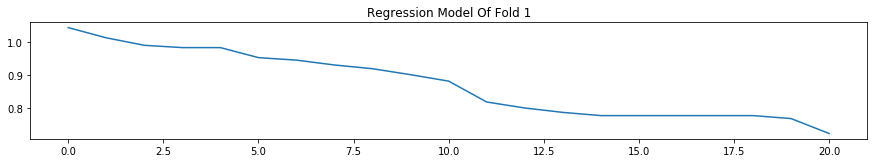

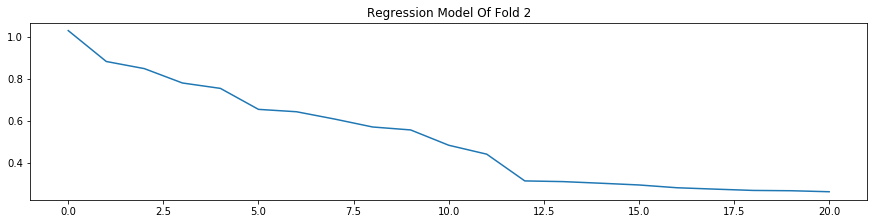

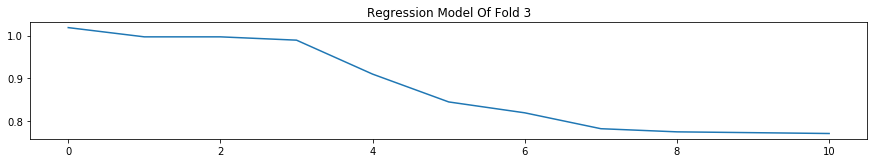

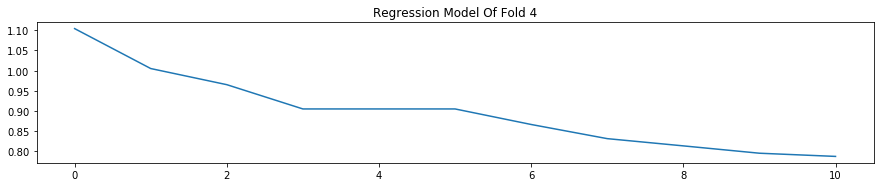

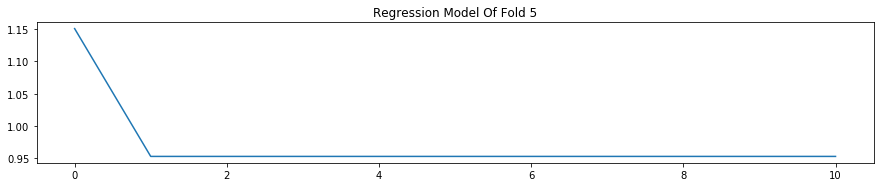

In [14]:
parms = list(itertools.product([2, 5, 10, 20, [5, 5], [10, 2, 10]], [10, 20, 100, 500]))
result = trainValidateTestKFolds(trainNN, evaluateNN, X, T, parms, nFolds=5, shuffle=False);
print('NN Model\n{:>30s} {:>10s} {:>10s} {:>10s}'.format('(Hidden Units, Iterations)', 'train', 'validate', 'test RMSE'))
for x in result:
     print('{:>30s} {:10.3f} {:10.3f} {:10.3f}'.format(str(x[0]), *x[1:]))

Results shows that the choice of best parameter set depends on the values of training data.

### $Graph$ $For$ $Neural$ $Network$

Final RMSE: train 0.000379144460823 test 15.0285105282
Final RMSE: train 2.0376162395e-05 test 2.23346646372e-05
Final RMSE: train 1.35392028359 test 0.435114392597
Final RMSE: train 8.59040873438e-05 test 0.000147961744393
Final RMSE: train 0.000800538034202 test 0.00154749307935


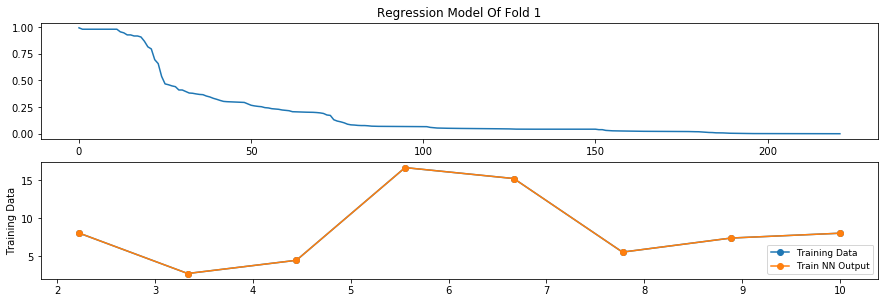

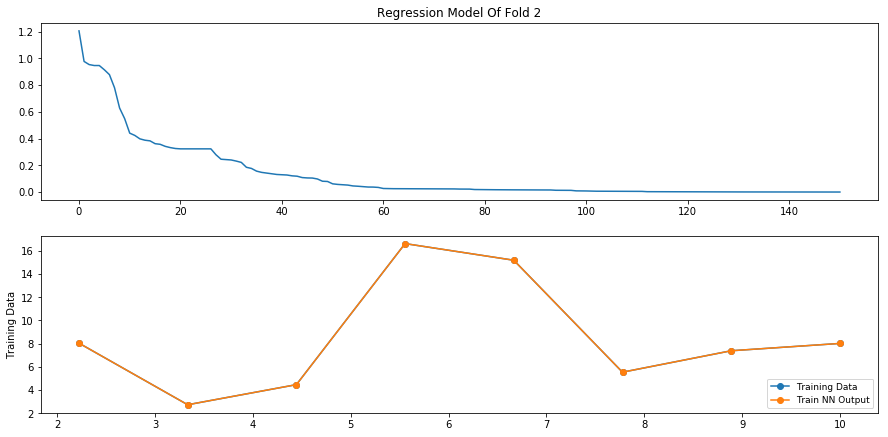

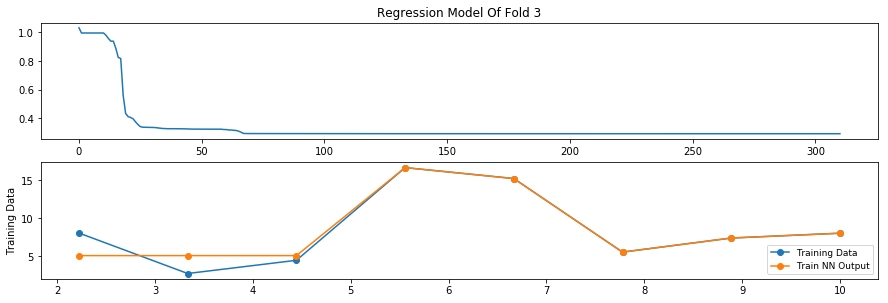

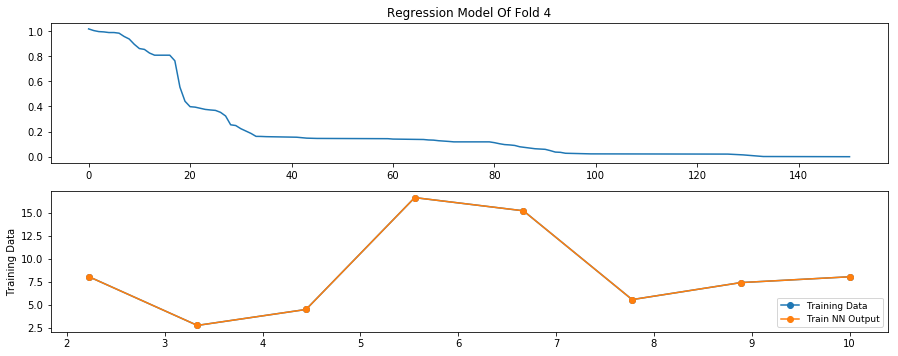

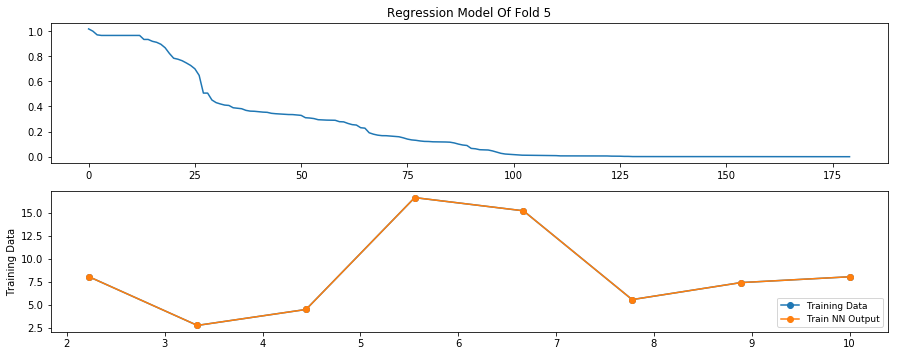

In [15]:
import matplotlib.pyplot as plt
import imp
I = np.array(I)
O = np.array(O)
y1 = np.array(y1)
y2 = np.array(y2)
IT = np.array(IT)
OT = np.array(OT)
nFolds = 5
for i in range(nFolds):
    
    pa = paro[i]
    nnet = nn.NeuralNetwork(1, pa[0] , 1)

    nnet.train(I[i], O[i], errorPrecision=1.e-10, weightPrecision=1.e-10, nIterations=1000)
    Y = nnet.use(I[i])
    plt.figure(figsize=(15, 15))

    nHLayers = len(nnet.nhs)
    nPlotRows = 3 + nHLayers
   
    plt.subplot(nPlotRows, 1, 1)
    plt.plot(nnet.getErrors())
    plt.title('Regression Model Of Fold %d'%(i+1))
    plt.subplot(nPlotRows, 1, 2)
    plt.plot(I[i], O[i], 'o-', label='Training Data')
    plt.plot(I[i], Y, 'o-', label='Train NN Output')
    plt.ylabel('Training Data')
    plt.legend(loc='lower right', prop={'size':9})

    Ytest, Ztest = nnet.use(IT[i], allOutputs=True)
    print("Final RMSE: train", np.sqrt(np.mean((Y-O[i])**2)), "test", np.sqrt(np.mean((Ytest-OT[i])**2)))     